## Drive mount

In [1]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [10]:
%cd /gdrive/My Drive/Colab Notebooks/Homework1.1

/gdrive/My Drive/Colab Notebooks/Homework1.1


## Libraries

In [3]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from keras.layers import BatchNormalization
from PIL import Image

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.9.2


In [ ]:
# Unzip in the colab folder for a quicker first epoch training
!unzip /gdrive/My\ Drive/Colab\ Notebooks/Homework1/dataset.zip > /dev/null

replace dataset/validation/Species 1/00028.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


## Variables

In [4]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

In [5]:
IMG_WIDTH = 96
IMG_HEIGHT = 96
IMG_DEPTH = 3
EPOCHS = 100
input_shape = (IMG_WIDTH, IMG_HEIGHT, IMG_DEPTH)

## Files directories and image generators

In [6]:
# Naming directories, images are split in roughly 85 % training and 15% validation per species
dataset_dir = 'dataset'
training_dir = os.path.join(dataset_dir, 'training')
validation_dir = os.path.join(dataset_dir, 'validation')

In [11]:
# Images are divided into folders, one for each class. 
# If the images are organized in such a way, we can exploit the 
# ImageDataGenerator to read them from disk.
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create an instance of ImageDataGenerator for the validation set
valid_data_gen = ImageDataGenerator(rescale = 1/255.)

# Data augmentation
# Define data generator and augmentation steps
data_gen = ImageDataGenerator(
                                        height_shift_range=20,
                                        width_shift_range=20,
                                        channel_shift_range = 0.01,
                                        brightness_range=(0.9,1.1),
                                        #rotation_range = 90,
                                        horizontal_flip=True,
                                        vertical_flip=True, 
                                        fill_mode='reflect',
                                        rescale=1/255.) # rescale value is multiplied to the image
# Obtain a data generator with the 'ImageDataGenerator.flow_from_directory' method
train_gen = data_gen.flow_from_directory(directory=training_dir,
                                               target_size=(IMG_WIDTH,IMG_HEIGHT),
                                               color_mode='rgb',
                                               classes=None, # can be set to labels
                                               class_mode='categorical',
                                               batch_size=8,
                                               shuffle=True,
                                               seed=seed)
valid_gen = valid_data_gen.flow_from_directory(directory=validation_dir,
                                               target_size=(IMG_WIDTH,IMG_HEIGHT),
                                               color_mode='rgb',
                                               classes=None, # can be set to labels
                                               class_mode='categorical',
                                               batch_size=8,
                                               shuffle=True,
                                               seed=seed)

Found 2829 images belonging to 8 classes.
Found 713 images belonging to 8 classes.


## Data inspection

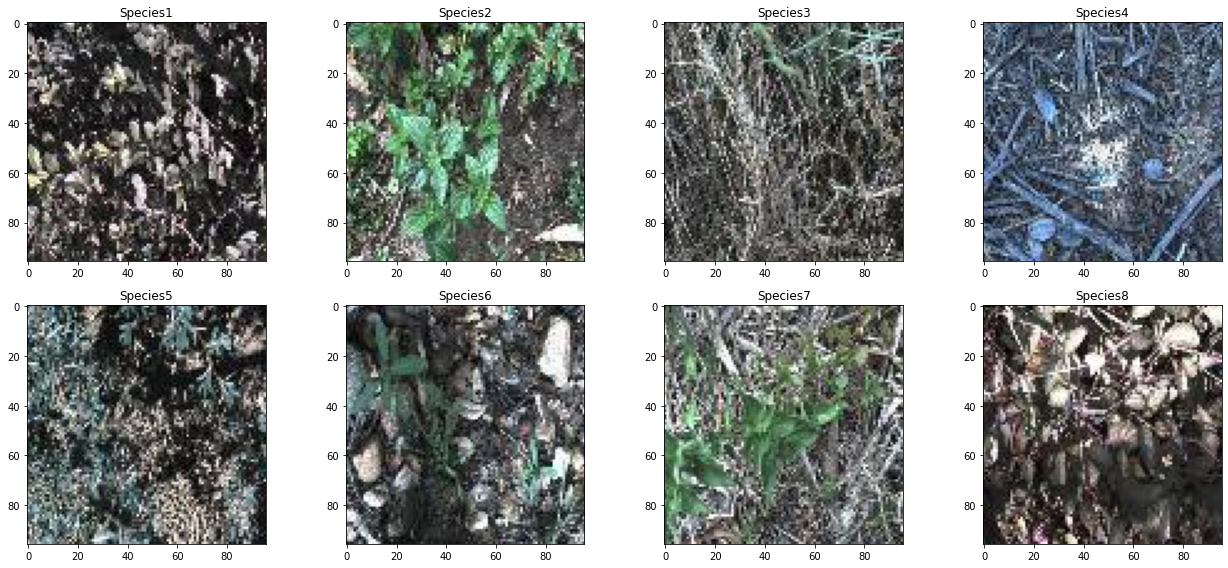

In [14]:
# Labels
labels = [
    'Species1', #0
    'Species2', #1
    'Species3', #2
    'Species4', #3
    'Species5', #4
    'Species6', #5
    'Species7', #6
    'Species8'  #7
]




num_row = 2
num_col = 4
fig, axes = plt.subplots(num_row, num_col, figsize=(9*num_row, 2*num_col))
for i in range(num_row*num_col):
  if i < 8:
    class_imgs = next(os.walk('{}/training/{}/'.format(dataset_dir, labels[i])))[2]
    class_img = class_imgs[0]  
    img = Image.open('{}/training/{}/{}'.format(dataset_dir, labels[i], class_img))
    ax = axes[i//num_col, i%num_col]
    ax.imshow(np.array(img))
    ax.set_title('{}'.format(labels[i]))
plt.tight_layout()
plt.show()

# Model definition

In [ ]:
def build_model(input_shape):

    # Define model layers

    l1_lambda = 1e-5

    input_layer = tfkl.Input((IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH))
    conv1 = tfkl.Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same',  kernel_initializer = tfk.initializers.HeUniform(seed))(input_layer)
    norm1 = tfkl.BatchNormalization()(conv1)
    pool1 = tfkl.MaxPooling2D()(norm1)  

    conv2 = tfkl.Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same',  kernel_initializer = tfk.initializers.HeUniform(seed))(pool1)
    norm2 = tfkl.BatchNormalization()(conv2)
    pool2 = tfkl.MaxPooling2D()(norm2)

    conv3 = tfkl.Conv2D(filters=128, kernel_size=(3,3), activation='relu', padding='same',  kernel_initializer = tfk.initializers.HeUniform(seed))(pool2)
    norm3 = tfkl.BatchNormalization()(conv3)
    pool3 = tfkl.MaxPooling2D()(norm3)

    conv4 = tfkl.Conv2D(filters=256, kernel_size=(3,3), activation='relu', padding='same',  kernel_initializer = tfk.initializers.HeUniform(seed))(pool3)
    norm4 = tfkl.BatchNormalization()(conv4)
    pool4 = tfkl.MaxPooling2D()(norm4)

    conv5 = tfkl.Conv2D(filters=512, kernel_size=(3,3), activation='relu', padding='same',  kernel_initializer = tfk.initializers.HeUniform(seed))(pool4)
    norm5 = tfkl.BatchNormalization()(conv5)
    pool5 = tfkl.MaxPooling2D()(norm5)

    flattening_layer = tfkl.Flatten()(pool5)    
    #dropout = tfkl.Dropout(0.3, seed=seed)(flattening_layer)

    classifier_layer = tfkl.Dense(
    units=128, 
    activation='relu',
    kernel_initializer = tfk.initializers.HeUniform(seed)
    )(flattening_layer)
    output_layer = tfkl.Dense(
    units=8, 
    activation='softmax', 
    kernel_initializer = tfk.initializers.GlorotUniform(seed),
    name='Output'
    )(classifier_layer)




    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

    # Return the model
    return model

## Callbacks utility functions

In [ ]:
# Utility function to create folders and callbacks for training
from datetime import datetime

def create_folders_and_callbacks(model_name):

    exps_dir = os.path.join('data_augmentation_experiments')
    if not os.path.exists(exps_dir):
      os.makedirs(exps_dir)

    now = datetime.now().strftime('%b%d_%H-%M-%S')

    exp_dir = os.path.join(exps_dir, model_name + '_' + str(now))
    if not os.path.exists(exp_dir):
      os.makedirs(exp_dir)

    callbacks = []

    # Model checkpoint
    # ----------------
    ckpt_dir = os.path.join(exp_dir, 'ckpts')
    if not os.path.exists(ckpt_dir):
      os.makedirs(ckpt_dir)

    ckpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(ckpt_dir, 'cp_{epoch}.ckpt'), 
                                                      save_weights_only=True, # True to save only weights
                                                     save_best_only=True) # True to save only the best epoch 
    callbacks.append(ckpt_callback)

    # Visualize Learning on Tensorboard
    # ---------------------------------
    tb_dir = os.path.join(exp_dir, 'tb_logs')
    if not os.path.exists(tb_dir):
      os.makedirs(tb_dir)

    # By default shows losses and metrics for both training and validation
    tb_callback = tf.keras.callbacks.TensorBoard(log_dir=tb_dir, 
                                               profile_batch=0,
                                               histogram_freq=1)  # if > 0 (epochs) shows weights histograms
    callbacks.append(tb_callback)

    # Early Stopping
    # --------------
    es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)
    callbacks.append(es_callback)



    # Learning rate regularization
    # ----------------------------

    lr_callback = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    min_delta=1e-10,
    patience=3,
    factor=0.2)

    #callbacks.append(lr_callback)

    return callbacks

### Weights calculation for class imbalance

In [ ]:
from sklearn.utils import class_weight
weights = class_weight.compute_class_weight(class_weight= 'balanced', 
                                            classes= np.unique(train_gen.classes),
                                            y = train_gen.classes)

### Model building

In [ ]:
model = build_model(input_shape)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 96, 96, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 96, 96, 32)       128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 48, 48, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 48, 48, 64)       256   

In [ ]:
# Create folders and callbacks and fit
aug_callbacks = create_folders_and_callbacks(model_name='Augm_besBrigh')

history = model.fit(epochs = EPOCHS, 
                    x = train_gen, 
                    validation_data = valid_gen, 
                    callbacks = aug_callbacks, 
                    class_weight = dict(enumerate(weights))).history

In [ ]:
model.save("experiments/Aug_Best6")

## Post training graphs and performance visualization

#### Training vs validation plots

In [ ]:
# Plot the training
plt.figure(figsize=(15,5))
plt.plot(history['loss'], label='Training', alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(history['val_loss'], label='Validation', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(history['accuracy'], label='Training', alpha=.8, color='#ff7f0e', linestyle='--')
plt.plot(history['val_accuracy'], label='Validation', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

#### Confusion matrix

In [ ]:

predictions = model.predict(valid_gen)
# Compute the confusion matrix
cm = confusion_matrix(valid_gen.classes, np.argmax(predictions, axis=-1))

# Compute the classification metrics
accuracy = accuracy_score(valid_gen.classes, np.argmax(predictions, axis=-1))
precision = precision_score(valid_gen.classes, np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(valid_gen.classes, np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(valid_gen.classes, np.argmax(predictions, axis=-1), average='macro')
print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(cm.T, xticklabels=list(labels), yticklabels=list(labels))
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()